1. [Load data bundle](#Load-data-bundle)

1. [Feature's Engineering](#Feature's-Engineering)
    1. [Factors' Engineering](#Factors'-Engineering)
    1. [Signals' Engineering](#Signals'-Engineering)
        
1. [Trading Algorithm with Random Forest Prediction](#Trading-Algorithm-with-Random-Forest-Prediction)
    1. [Random-Forest-Model-Design](#Random-Forest-Model-Design)
    1. [Plug-in RF implementation into Trading Bot](#Plug-in-RF-implementation-into-Trading-Bot)
    1. [Backtest ML Trading Strategy](#Backtest-ML-Trading-Strategy)

## Import Libraries

In [1]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data bundle
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [3]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [4]:
bundle_data = bundles.load('quandl')

In [5]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


In [6]:
end_date = pd.Timestamp("2018-03-27", tz="utc")

In [7]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00+0000', tz='UTC')

In [8]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("NYSE"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

In [9]:
AAPL = data_por.asset_finder.lookup_symbol(
    'AAPL',
    as_of_date=None
)

In [10]:
df = data_por.get_history_window(
    assets=[AAPL],
    end_dt=end_date,
    bar_count=7000,
    frequency='1d',
    data_frequency='daily',
    field='open'
)

In [11]:
df.tail()

,Equity(8 [AAPL])
2018-03-21 00:00:00+00:00,175.04
2018-03-22 00:00:00+00:00,170.00
2018-03-23 00:00:00+00:00,168.39
2018-03-26 00:00:00+00:00,168.07
2018-03-27 00:00:00+00:00,173.68


In [12]:
df.index = pd.DatetimeIndex(df.index)

In [13]:
df['close'] = df[list(df.columns)[0]]

In [14]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,close
1990-06-15 00:00:00+00:00,39.75
1990-06-18 00:00:00+00:00,39.25
1990-06-19 00:00:00+00:00,39.00
1990-06-20 00:00:00+00:00,39.88
1990-06-21 00:00:00+00:00,40.00


# Feature's Engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In this section, we shall deal with simple returns and enrich our DataFrame with new features. <br>

In finance, there are three important sources of data for quantitative analysis: <br>
<ol>
    <li>Technical data (OHLCV)</li>
    <li>Fundamental Analysis (companies' value)</li>
    <li>Alternative Analysis (sentiment analysis, news analysis, geolocalisation, etc)</li>
</ol> 
With <b>technical analysis</b>, we shall look into historical patterns that may reproduce in the future.
<b>Fundamental analysis</b> is in turn useful to assess value indicators of listed companies.
<b>Alternative analysis</b> may provide additionnal explanatory power to estimate to our target.<br>

Let's, for the moment, stick to technical analysis and build 40-days lagged closing price variables according to the following model logic: with 32-days historical prices, let's predict 8 stock prices ahead.

## Factors' Engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [15]:
df['1d'] = df.shift(-1)

In [16]:
for d in range(2, 41):
    col = '%dd'% d
    df[col] = df['close'].shift(-1 * d)

In [17]:
df = df.dropna()

In [18]:
df.head()

,close,1d,2d,3d,4d,5d,6d,7d,8d,9d,10d,11d,12d,13d,14d,15d,16d,17d,18d,19d,20d,21d,22d,23d,24d,25d,26d,27d,28d,29d,30d,31d,32d,33d,34d,35d,36d,37d,38d,39d,40d
1990-06-15 00:00:00+00:00,39.75,39.25,39.00,39.88,40.00,42.00,41.50,41.75,40.75,42.75,43.00,44.50,43.88,43.75,43.50,45.00,47.00,46.75,46.75,47.50,46.75,45.75,44.50,40.75,42.00,41.00,42.00,42.00,42.25,41.25,40.75,42.50,42.00,41.25,43.50,39.00,40.25,39.50,40.25,38.75,38.0
1990-06-18 00:00:00+00:00,39.25,39.00,39.88,40.00,42.00,41.50,41.75,40.75,42.75,43.00,44.50,43.88,43.75,43.50,45.00,47.00,46.75,46.75,47.50,46.75,45.75,44.50,40.75,42.00,41.00,42.00,42.00,42.25,41.25,40.75,42.50,42.00,41.25,43.50,39.00,40.25,39.50,40.25,38.75,38.00,40.0
1990-06-19 00:00:00+00:00,39.00,39.88,40.00,42.00,41.50,41.75,40.75,42.75,43.00,44.50,43.88,43.75,43.50,45.00,47.00,46.75,46.75,47.50,46.75,45.75,44.50,40.75,42.00,41.00,42.00,42.00,42.25,41.25,40.75,42.50,42.00,41.25,43.50,39.00,40.25,39.50,40.25,38.75,38.00,40.00,40.0
1990-06-20 00:00:00+00:00,39.88,40.00,42.00,41.50,41.75,40.75,42.75,43.00,44.50,43.88,43.75,43.50,45.00,47.00,46.75,46.75,47.50,46.75,45.75,44.50,40.75,42.00,41.00,42.00,42.00,42.25,41.25,40.75,42.50,42.00,41.25,43.50,39.00,40.25,39.50,40.25,38.75,38.00,40.00,40.00,39.0
1990-06-21 00:00:00+00:00,40.00,42.00,41.50,41.75,40.75,42.75,43.00,44.50,43.88,43.75,43.50,45.00,47.00,46.75,46.75,47.50,46.75,45.75,44.50,40.75,42.00,41.00,42.00,42.00,42.25,41.25,40.75,42.50,42.00,41.25,43.50,39.00,40.25,39.50,40.25,38.75,38.00,40.00,40.00,39.00,38.5


Let's now split the series between features and targets.

In [19]:
# Create features (X) and targets (y)
X = df.iloc[:,:33]
y = df.iloc[:,33:]


# Trading Algorithm with Random Forest Prediction
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Import Libraries

In [20]:
# Sklearn model selection
from sklearn.model_selection import train_test_split

# Regressors
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout

# Data Scaling (for KNN-neighbours)
from sklearn.preprocessing import scale

# Hyperparameter tuning
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import r2_score

# Neural Networks loss function
# import keras.losses
# import tensorflow as tf


<b>Neural Networks and Zipline</b><br>
<code>Keras</code> and <code>Tensorflow</code> are not supported in local Zipline research environment. Though having installed both, a message error is displayed when importing them. To date, no satisfactory and technically feasible solutions have been found to port the DL algorithm into the Zipline local platform. For that reason, and regrettably enough, deep learning models cannot be performed in this project but will be explored in the future, hopefully in a Zipline environment.<br>
Particularly,Long-Short Term Memory (LSTM) and Echo State Networks (ESN) models that is,  Recurrent Neural Networks, seem to work fine with financial time series, since they are able to capture non-linear relationships among variables and correct for vanishing gradient descents.

<b>Step-by-step approach</b><br>
In this section, we shall
<ul>
    <li>instantiate ML models</li>
    <li>perform hyperparameter tuning and cross-validation</li>
    <li>train our models, perform predictions and measure errors</li>
    <li>export results in a joblib format</li>
    <li>plug-in joblib RF regressor into our trading bot</li>
</ul>
    

### Train, Test, Split

Considering that financial times series is not independent and identically distibuted, on grounds of serial autocorrelation and time-varying standard deviation, we shall prevent the series split from shuffling. Further on, we shall use TimeSeriesSplit object from sklearn to allow for incremental cross validation.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, train_size = 0.85, random_state = 1)

In [22]:
X_train.shape

(5846, 33)

In [25]:
X_test.shape

(1032, 33)

## Random-Forest-Model-Design
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

As for now, we shall use sklearn's Parameter Grid to tailor our hyperparameters search and retrieve the best performing one. We then fit and predict the RF and calculate our MSE scores.

In [23]:
# First, create an Instance
regressor = RandomForestRegressor()

# Second, create a dictionnary of hyperparameters to search
grid = {'n_estimators': [100, 200], 'max_depth': [3, 7], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Third, loop over the parameter grid, set the hyperparameters and save the scores
for g in ParameterGrid(grid):
    regressor.set_params(**g) # unpack the dictionnary
    regressor.fit(X_train, y_train)
    test_scores.append(regressor.score(X_test, y_test))
    
# Fourth, find best hyperparameters
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])
    

0.9101405503176044 {'n_estimators': 200, 'max_depth': 7, 'max_features': 8, 'random_state': 42}


In [24]:
# Instantiate the model
regressor = RandomForestRegressor(n_estimators = 200, max_depth = 5, max_features = 8, random_state = 42)

# Fit the model
regressor.fit(X_train, y_train)

# Make predictions
train_pred_rfr = regressor.predict(X_train)
test_pred_rfr = regressor.predict(X_test)

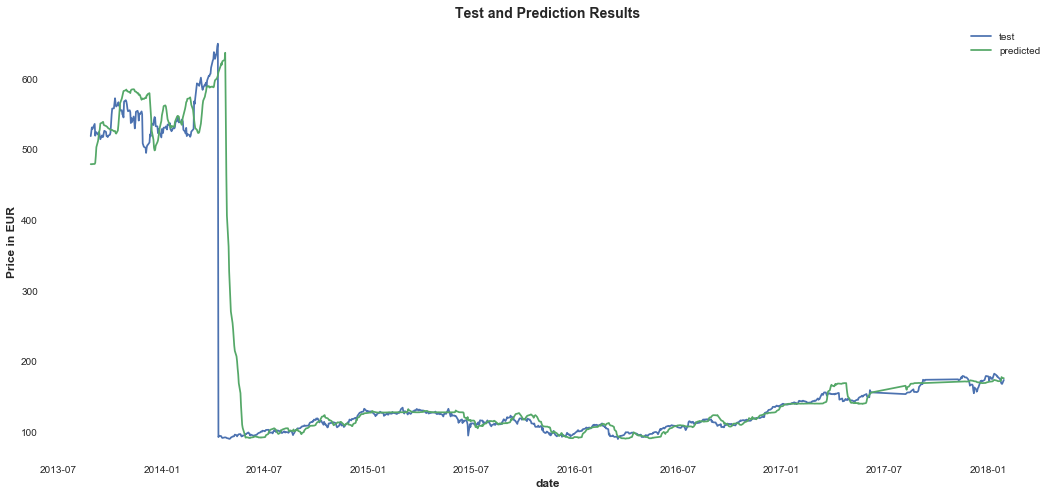

0.9974298479136544
0.909883586027943


In [34]:
# Set initial plot options
# sns.set_style('white')
plt.figure(figsize = (18, 8))

# Create a lineplot
sns.lineplot(x = y_test.index,
             y = y_test['40d'], 
             # Change colors for each hue category
             palette = ["r"], 
             # Add points to lineplot and remove confidence interval
             markers = 'o', ci = None, label='test')
sns.lineplot(x = y_test.index,
             y = test_pred_rfr[:,7], 
             # Change colors for each hue category
             palette = ["g"], 
             # Add points to lineplot and remove confidence interval
             markers = 'o', ci = None, label='predicted')

# Final formatting
plt.xlabel("date", fontsize = 12, fontweight = "semibold")
plt.ylabel("Price in EUR", fontsize = 12, fontweight = "semibold")
plt.title("Test and Prediction Results", fontsize = 14, fontweight = "semibold")
plt.show()

# Print scores
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

In [28]:
# Last day prediction (for the eight following days)
test_pred_rfr[-1,:]

array([176.53137954, 176.65627176, 176.71447498, 176.70545694,
       176.61889651, 176.5031013 , 176.34499538, 176.17127957])

In [29]:
# Export trained models and save it for future predictions
from joblib import dump
dump(regressor, '../strategies/models/rfr_regressor.joblib')

['../strategies/models/rfr_regressor.joblib']

## Plug-in RF implementation into Trading Bot
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

We modify the <code>buy_and_hold.py</code> Python script (strategies folder) to account for, ceteris paribus:
<ul>
    <li>lagged and forecast values</li>
    <li>under the <code>initialize </code>function, load our RF regressor joblib </li>
    <li>under the <code>handle_data</code> function:<br>
        <ol>
        <li>create one array with lagged 32 values for each point in time and  one array with 8 forecast values, and</li>
        <li>code the strategy: if the max predictive value is above the mean of historical/past values, then we place a buy order and viceversa</li>
        </ol>
    

The portfolio value has reached a value of round 228 million EUR, whereas the classic strategy BuyAndHold recorded a value of round 561.100 EUR.

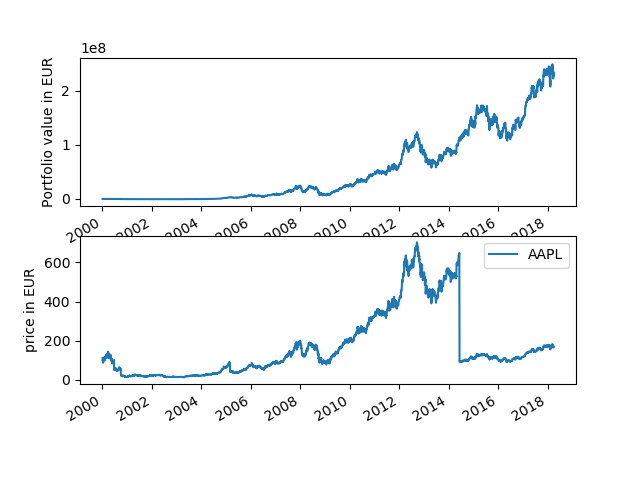

## Backtest ML Trading Strategy
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [35]:
df = pd.read_csv('../reports/buy_and_hold.csv')

In [36]:
df = df.rename(columns={'Unnamed: 0':'date'}).set_index('date')

<Figure size 1296x576 with 0 Axes>

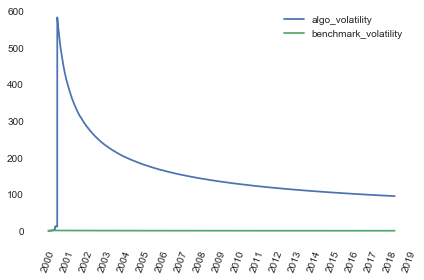

In [48]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algo_volatility)
ax.plot(df.index, df.benchmark_volatility)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

<Figure size 1296x576 with 0 Axes>

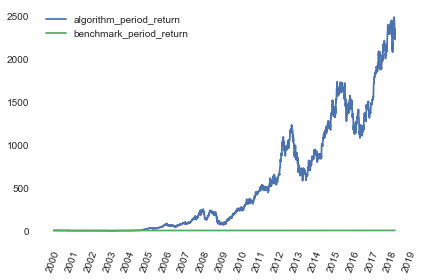

In [49]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algorithm_period_return)
ax.plot(df.index, df.benchmark_period_return)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

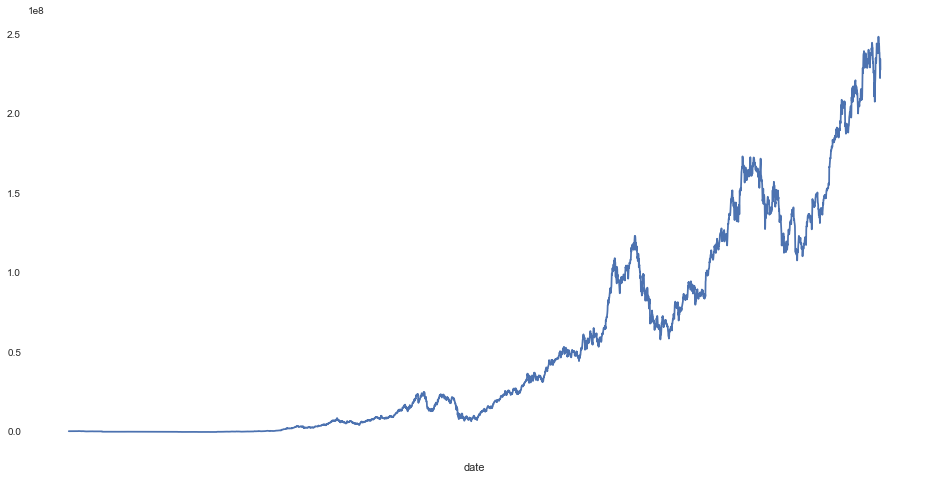

In [37]:
df.portfolio_value.plot(figsize=(16,8))

In [38]:
'${:.2f}'.format(df.capital_used.sum())

'$-33730147.25'

In [39]:
'${:.2f}'.format(df.portfolio_value[-1])

'$227667200.75'

In [40]:
'${:.2f}'.format(df.capital_used.sum() + df.portfolio_value[-1])

'$193937053.51'

## Gradient Boosting Models
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Gradient Boosting Model

In [42]:
# Create GB model -- hyperparameters (to be tuned!!)
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(X_train, y_train)

print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

ValueError: bad input shape (5846, 8)